In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd


def nuclear_norm_minimization(M, mask):
    # Nuclear norm minimization problem
    X = cp.Variable(shape=M.shape, name="X")
    objective = cp.Minimize(cp.norm(X, "nuc"))
    constraints = [cp.multiply(mask, X) == cp.multiply(mask, M)]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    return X.value

def iterative_2_by_2_solver(M, mask, print_success_log=True):
    # identify 2x2 submatrices [A B,C *] with just one missing entry and compute it as
    # * = CB/A. Repeat until none are left
    M_hat = np.copy(M) * mask
    # print(M_hat)
    resolved_submatrices = 1
    unresolved_submatrices = 0
    while(resolved_submatrices > 0):
        # print("resloved_submatrices={}".format(resolved_submatrices))
        # print("unresloved_submatrices={}".format(unresolved_submatrices))
        resolved_submatrices = 0
        unresolved_submatrices = 0
        for i in range(mask.shape[0]-1):
            for j in range(mask.shape[1]-1):
                if (mask[i, j] == 0) and (mask[i+1, j] + mask[i, j+1] + mask[i+1, j+1]) == 3:
                    # fill up first entry
                    M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
                    mask[i, j] = 1
                    resolved_submatrices += 1
                elif (mask[i+1, j] == 0) and (mask[i, j] + mask[i, j+1] + mask[i+1, j+1]) == 3:
                    M_hat[i+1, j] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i, j+1]
                    mask[i+1, j] = 1
                    resolved_submatrices += 1
                elif (mask[i, j+1] == 0) and (mask[i, j] + mask[i+1, j] + mask[i+1, j+1]) == 3:
                    M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
                    mask[i, j+1] = 1
                    resolved_submatrices += 1
                elif (mask[i+1, j+1] == 0) and (mask[i, j] + mask[i+1, j] + mask[i, j+1]) == 3:
                    M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
                    mask[i+1, j+1] = 1
                    resolved_submatrices += 1
                elif (mask[i+1, j+1] + mask[i, j] + mask[i+1, j] + mask[i, j+1]) == 4:
                    # already solved!
                    continue
                else:
                    # unresolved matrix
                    unresolved_submatrices += 1
        success_flag = 0
        if unresolved_submatrices > 0:
            if print_success_log:
                print("Couldn't complete matrix")
        else:
            success_flag = 1
            if print_success_log:
                print("Success!")
    return M_hat, success_flag
    

def relaxed_nuclear_norm_minimization(M, mask, eps=1e-3):
    # Nuclear norm minimization problem. relax so that seen entries have to be within "eps"
    X = cp.Variable(shape=M.shape, name="X")
    objective = cp.Minimize(cp.norm(X, "nuc"))
    constraints = [cp.norm(cp.multiply(mask, X)-cp.multiply(mask, M), 2) <= eps]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    return X.value

# def generate_matrix_and_mask(n, reveal_count):
#     # Generate matrix M and mask
#     vec = np.arange(1, n + 1).reshape(-1, 1)
#     M = vec.dot(vec.T)
#     mask = np.zeros_like(M)
#     reveal_indices = np.random.choice(n**2, reveal_count, replace=False)
#     mask.ravel()[reveal_indices] = 1
#     return M, mask

def generate_matrix_and_mask(n, reveal_count):
    # Generate matrix M and mask
    vec = np.arange(n).reshape(-1, 1)
    one = np.ones((n, 1))
    M = vec.dot(one.T) + one.dot(vec.T)
    mask = np.zeros_like(M)
    reveal_indices = np.random.choice(n**2, reveal_count, replace=False)
    mask.ravel()[reveal_indices] = 1
    return M, mask

def calculate_mse(M1, M2):
    # Mean squared error between two matrices
    return np.mean((M1 - M2)**2)

def calculate_acc(M1, M2, eps_error=1e-3):
    # Check accuracy of model. If error < 1e-3, I call it correct
    return np.mean((M1 - M2) < eps_error)

def plot_results(revealed_entries, mse_values, acc_values, metric='mse', n=10):
    plt.figure(figsize=(8,6))
    if metric == 'mse':
        plt.plot(revealed_entries, mse_values, marker='o', linewidth=4, markersize=6)
    else:
        plt.plot(revealed_entries, [100*acc_val for acc_val in acc_values],
                 marker='o', linewidth=4, markersize=6)
    y_label = 'MSE' if metric == 'mse' else 'Accuracy'
    plt.xlabel('Number of Revealed Entries', fontsize=24)
    plt.ylabel(f'{y_label}', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.title(f'addition of numbers up to {n}', fontsize=20)
    plt.savefig(f'maxtrixcompletion_n={n}_log.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)
    plt.show()

def generate_addition_dataset(M, mask, n=10, reveal_count=10):
    filename = f'addition_train_{n}_{reveal_count}.txt'
    print(f'generating {filename}')
    revealed_indices = np.argwhere(mask == 1)
    with open(filename, 'w') as f:
        for i,j in revealed_indices:
            f.write(f'{i}+{j}={int(M[i,j])}\n')
            


In [25]:
def create_test_data(filename):
    test_file = filename.replace('train', 'test')
    print(f'generating {test_file}')
    with open(filename, 'r') as f:
        data = f.read()
    with open(test_file, 'w') as f:
        count = 0 
        for i in range(100):
            for j in range(100):
                if f'{i}+{j}={i+j}\n' not in data:
                    count += 1
                    f.write(f'{i}+{j}={i+j}\n')
        print(f'wrote {count} lines to {test_file}')

In [26]:
import glob
file_list = glob.glob('addition_train_*.txt')
for filename in file_list:
    create_test_data(filename)

generating addition_test_100_1800.txt
wrote 8200 lines to addition_test_100_1800.txt
generating addition_test_100_5000.txt
wrote 5000 lines to addition_test_100_5000.txt
generating addition_test_100_1200.txt
wrote 8800 lines to addition_test_100_1200.txt
generating addition_test_100_2000.txt
wrote 8000 lines to addition_test_100_2000.txt
generating addition_test_100_1000.txt
wrote 9000 lines to addition_test_100_1000.txt
generating addition_test_100_500.txt
wrote 9500 lines to addition_test_100_500.txt
generating addition_test_100_100.txt
wrote 9900 lines to addition_test_100_100.txt
generating addition_test_100_1500.txt
wrote 8500 lines to addition_test_100_1500.txt


/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2

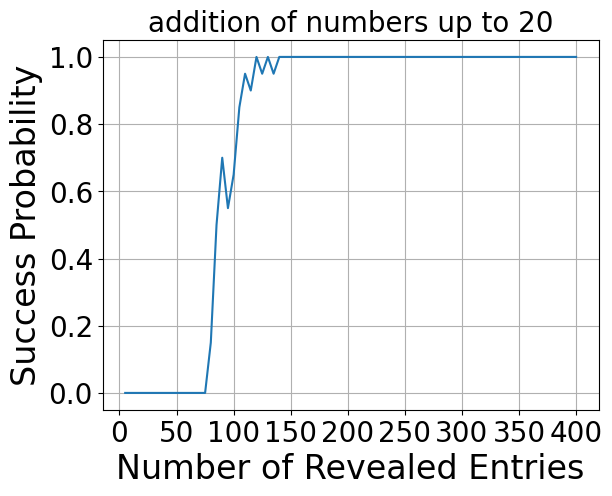

In [33]:
n = 20
num_trials = 20
revealed_entries = range(5, n**2 + 1, 5)
mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    # print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

    result_dict = {'revealed_entries': revealed_entries[:len(mse_values)],'mse_values': mse_values, 'acc_values': acc_values, 'success_prob_values': success_prob_values}
    df = pd.DataFrame(result_dict)
    df.to_csv(f'iterative_mc_results_n={n}.csv', index=False)

plt.plot(revealed_entries, success_prob_values)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.show()

/tmp/ipykernel_1237/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_1237/2286715377.py:40: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_1237/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_1237/2286715377.py:40: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_1237/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_1237/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_1237/2286715377.py:44: Runti

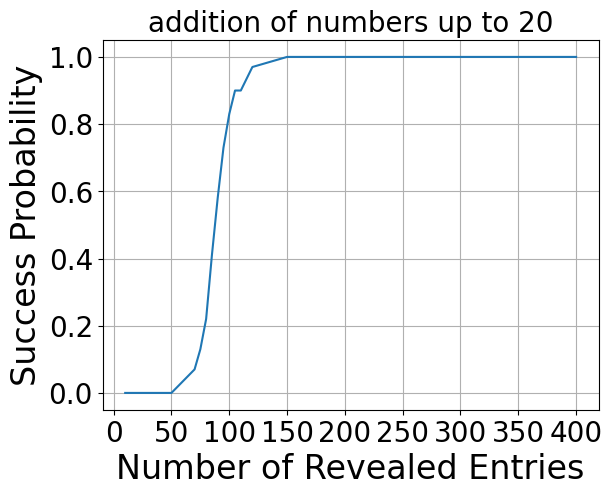

In [5]:
n = 20
num_trials = 100
revealed_entries = [10,20,50,70,75,80,85,90,95,100,105,110,120,150,200,250,300,400]
mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    # print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

    result_dict = {'revealed_entries': revealed_entries[:len(mse_values)],'mse_values': mse_values, 'acc_values': acc_values, 'success_prob_values': success_prob_values}
    df = pd.DataFrame(result_dict)
    df.to_csv(f'iterative_mc_results_n={n}.csv', index=False)

plt.plot(revealed_entries, success_prob_values)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.show()

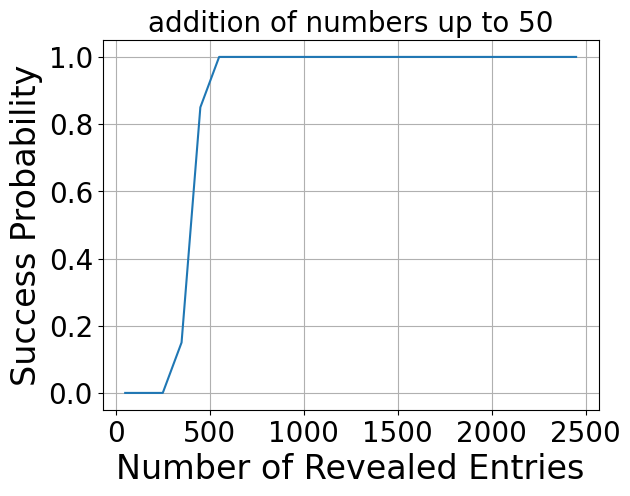

In [18]:
n = 50
num_trials = 20
revealed_entries = range(50, n**2 + 1, 100)
mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

plt.plot(revealed_entries, success_prob_values)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.show()

Reveal count: 20
Reveal count: 70
Reveal count: 120
Reveal count: 170
Reveal count: 220
Reveal count: 270
Reveal count: 320
Reveal count: 370
Reveal count: 420
Reveal count: 470
Reveal count: 520
Reveal count: 570
Reveal count: 620
Reveal count: 670
Reveal count: 720
Reveal count: 770
Reveal count: 820


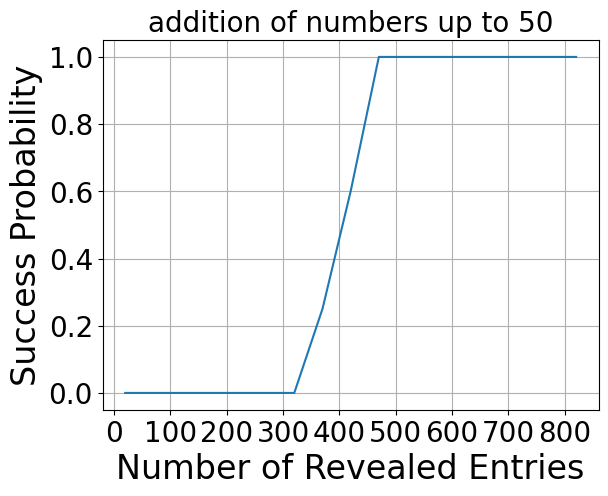

In [19]:
n = 50
num_trials = 20
revealed_entries = range(20, 821, 50)
mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

plt.plot(revealed_entries, success_prob_values)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.show()

Reveal count: 100
Reveal count: 1100
Reveal count: 2100
Reveal count: 3100
Reveal count: 4100
Reveal count: 5100
Reveal count: 6100


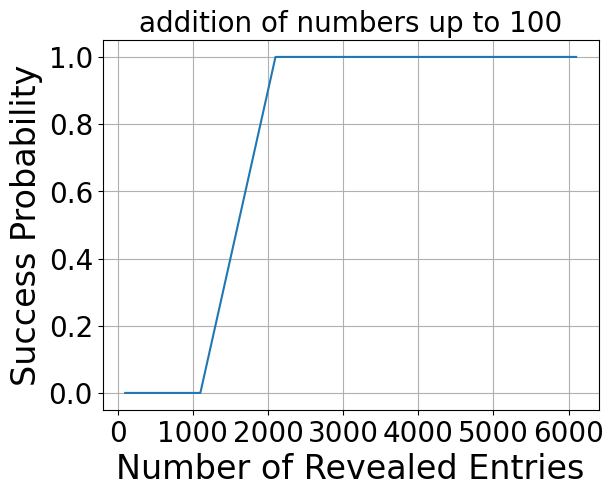

In [20]:
n = 100
num_trials = 20
revealed_entries = range(100, 7000 + 1, 1000)

mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

plt.plot(revealed_entries, success_prob_values)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.show()

Reveal count: 100
Reveal count: 500
Reveal count: 1000
Reveal count: 1200
Reveal count: 1500
Reveal count: 1800
Reveal count: 2000
Reveal count: 5000


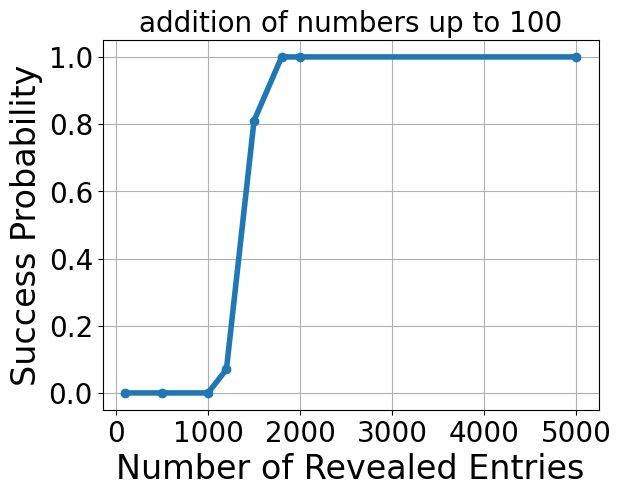

In [7]:
n = 100
num_trials = 100
# revealed_entries = range(100, n**2 + 1, 1000)
# revealed_entries = range(100, 1101, 100)
revealed_entries = [100,500,1000,1200,1500,1800,2000,5000]

mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

plt.plot(revealed_entries, success_prob_values, marker='o', linewidth=4, markersize=6)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.savefig(f'maxtrixcompletion_n={n}_iterative.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)
# plt.show()

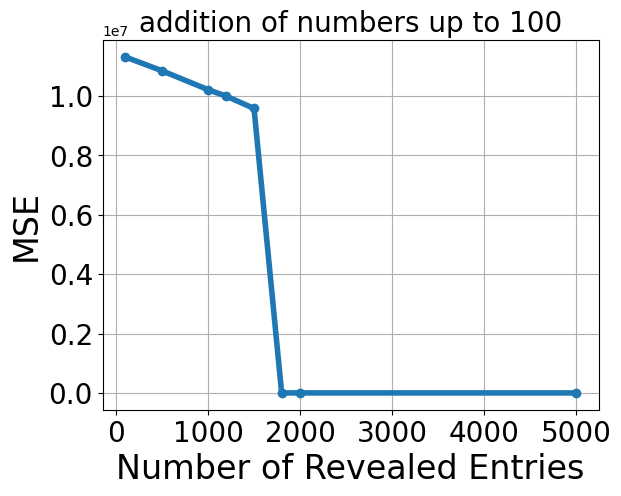

In [8]:
plot_results(revealed_entries, mse_values, acc_values, metric='mse', n=n)

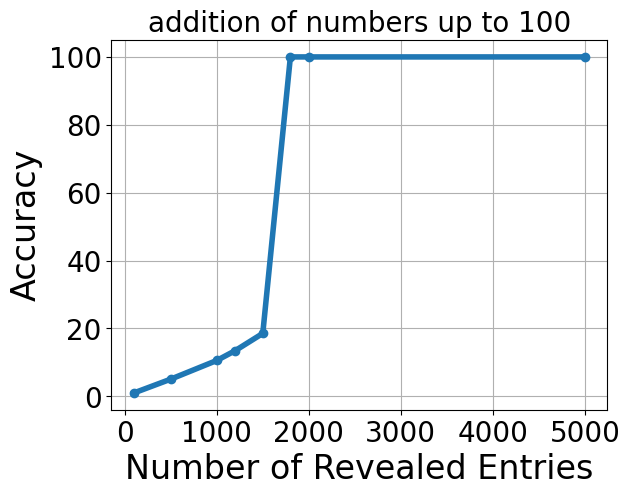

In [9]:
plot_results(revealed_entries, mse_values, acc_values, metric='acc', n=n)

Reveal count: 5000
Reveal count: 10000
Reveal count: 20000
Reveal count: 22000
Reveal count: 25000


/tmp/ipykernel_2946941/2286715377.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:40: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_2946941/2286715377.py:40: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/228671537

Reveal count: 28000


/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: overflow encountered in scalar divide
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:3

Reveal count: 30000


/tmp/ipykernel_2946941/2286715377.py:36: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i+1, j] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i, j+1]
/tmp/ipykernel_2946941/2286715377.py:36: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i, j+1]
/tmp/ipykernel_2946941/2286715377.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i, j+1]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:32: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i+1, j+1]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/228671537

Reveal count: 40000


/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: overflow encountered in scalar multiply
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_2946941/2286715377.py:44: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]


Reveal count: 50000


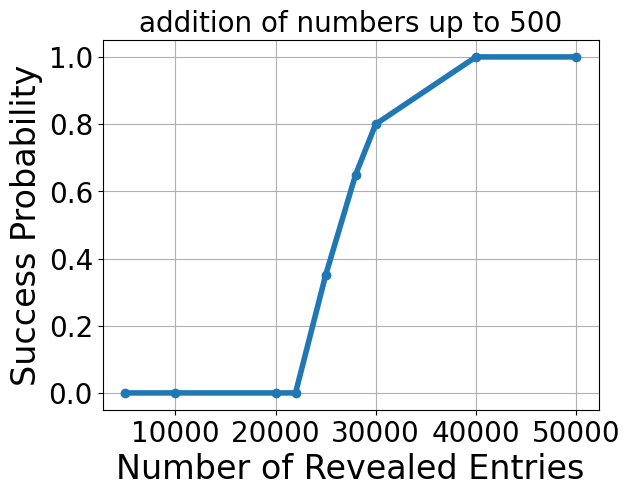

In [34]:
n = 500
num_trials = 20
# revealed_entries = range(100, n**2 + 1, 1000)
# revealed_entries = range(100, 1101, 100)
revealed_entries = [5000, 10000, 20000, 22000, 25000, 28000, 30000, 40000, 50000]

mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    if reveal_count >= 30000:
        num_trials = 5
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

    result_dict = {'revealed_entries': revealed_entries[:len(mse_values)],'mse_values': mse_values, 'acc_values': acc_values, 'success_prob_values': success_prob_values}
    df = pd.DataFrame(result_dict)
    df.to_csv(f'iterative_mc_results_n={n}.csv', index=False)
    

plt.plot(revealed_entries, success_prob_values, marker='o', linewidth=4, markersize=6)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.savefig(f'maxtrixcompletion_n={n}_iterative.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)
# plt.show()

In [ ]:
n = 100
num_trials = 100
# revealed_entries = range(100, n**2 + 1, 1000)
# revealed_entries = range(100, 1101, 100)
revealed_entries = [100,500,1000,1200,1500,1800,2000,5000]

mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        if trial == 0:
            generate_addition_dataset(M, mask, n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

    result_dict = {'revealed_entries': revealed_entries[:len(mse_values)],'mse_values': mse_values, 'acc_values': acc_values, 'success_prob_values': success_prob_values}
    df = pd.DataFrame(result_dict)
    df.to_csv(f'iterative_mc_results_n={n}.csv', index=False)

plt.plot(revealed_entries, success_prob_values, marker='o', linewidth=4, markersize=6)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.savefig(f'maxtrixcompletion_n={n}_iterative.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)
# plt.show()

Reveal count: 100
generating addition_train_100_100.txt
Reveal count: 500
generating addition_train_100_500.txt
Reveal count: 1000
generating addition_train_100_1000.txt
Reveal count: 1200
generating addition_train_100_1200.txt
Reveal count: 1500
generating addition_train_100_1500.txt
Reveal count: 1800
generating addition_train_100_1800.txt


/tmp/ipykernel_3011652/1343622041.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]
/tmp/ipykernel_3011652/1343622041.py:34: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i, j+1]


Reveal count: 2000
generating addition_train_100_2000.txt


/tmp/ipykernel_3011652/1343622041.py:38: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i, j+1] = M_hat[i, j] * M_hat[i+1, j+1]/M_hat[i+1, j]
/tmp/ipykernel_3011652/1343622041.py:42: RuntimeWarning: invalid value encountered in scalar divide
  M_hat[i+1, j+1] = M_hat[i+1, j] * M_hat[i, j+1]/M_hat[i, j]


Reveal count: 5000
generating addition_train_100_5000.txt


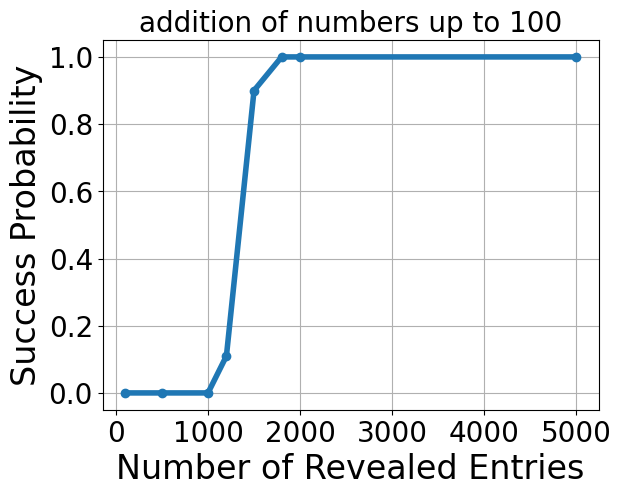

In [ ]:
n = 100
num_trials = 100
# revealed_entries = range(100, n**2 + 1, 1000)
# revealed_entries = range(100, 1101, 100)
revealed_entries = [100,500,1000,1200,1500,1800,2000,5000]

mse_values = []
acc_values = []
success_prob_values = []

for reveal_count in revealed_entries:
    print("Reveal count: {}".format(reveal_count))
    success_prob = 0
    for trial in range(num_trials):
        M, mask = generate_matrix_and_mask(n, reveal_count)
        if trial == 0:
            generate_addition_dataset(M, mask, n, reveal_count)
        M_hat, success_flag = iterative_2_by_2_solver(M, mask, False)
        success_prob += success_flag
    # print("Reveal count: {} | prob={}".format(reveal_count, success_prob))
    mse_values.append(calculate_mse(M, M_hat))
    acc_values.append(calculate_acc(M, M_hat))
    success_prob_values.append(1.0*success_prob/num_trials)

plt.plot(revealed_entries, success_prob_values, marker='o', linewidth=4, markersize=6)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title(f'addition of numbers up to {n}', fontsize=20)
plt.savefig(f'maxtrixcompletion_n={n}_iterative.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)
# plt.show()

['iterative_mc_results_n=20.csv', 'iterative_mc_results_n=50.csv', 'iterative_mc_results_n=100.csv', 'iterative_mc_results_n=500.csv']


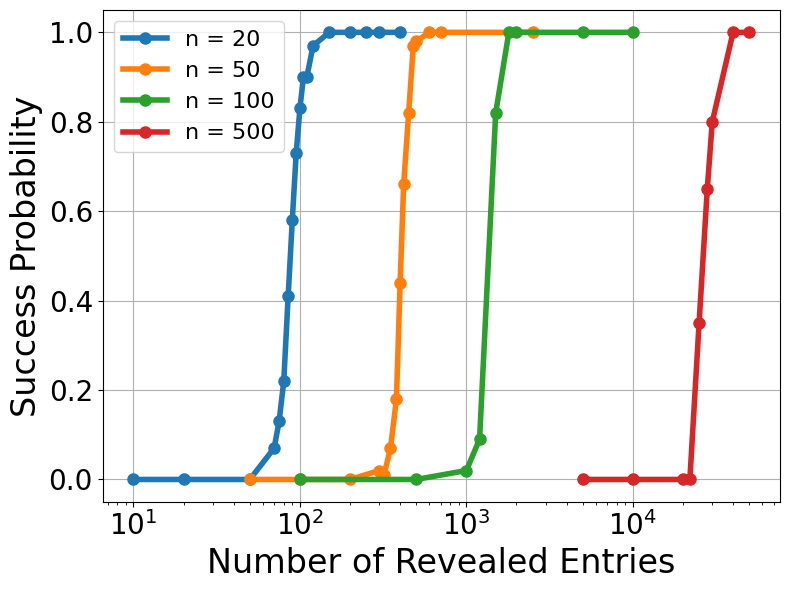

In [3]:
name = 'matrix_completions'

methods = ['plain', 'ar']
numbers = [20,50,100,500]
labels = [f'n = {x}' for x in numbers]

plt.figure(figsize=(8,6))
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # for few-shot prompting evaluation

files = [
    'iterative_mc_results_n=20.csv',
    'iterative_mc_results_n=50.csv',
    'iterative_mc_results_n=100.csv',
    'iterative_mc_results_n=500.csv'
]
print(files)
for i, file in enumerate(files):
    df = pd.read_csv(file)
    keys = df.keys()
    df.sort_values(by=['revealed_entries'], inplace=True)
    # num_ar = df['num_train_samples'].unique()

    # df_mean = df.groupby('num_train_samples').mean()
    # df_min = df.groupby('num_train_samples').min()
    # df_max = df.groupby('num_train_samples').max()

    plt.plot(df.revealed_entries, df.success_prob_values, label=labels[i], color=colors[i], marker='o', linewidth=4, markersize=8)


# plt.title("NanoGPT, Algorithmic Reasoning Accuracy", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlim(700, 7000)
# plt.ylim(0, 100)
plt.xscale('log')
# plt.xticks([0,5000,10000,15000, 20000, 25000, 30000, 35000, 40000], 
#            ["0", "5k", "10k", "15k", "20k", "25k", "30k", "35k", "40k"], fontsize=20)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
plt.legend(loc='upper left', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.savefig(f'{name}.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)

['iterative_mc_results_n=20.csv', 'iterative_mc_results_n=50.csv', 'iterative_mc_results_n=100.csv', 'iterative_mc_results_n=500.csv']


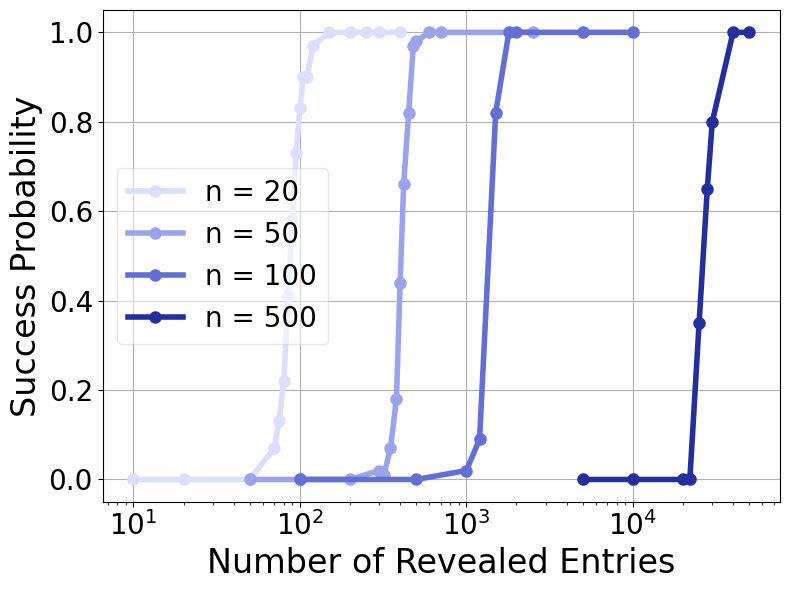

In [27]:
name = 'matrix_completions'

methods = ['plain', 'ar']
numbers = [20,50,100,500]
labels = [f'n = {x}' for x in numbers]

plt.figure(figsize=(8,6))
colors =  ['#DBDFFD', '#9BA3EB', '#646FD4', '#242F9B']

files = [
    'iterative_mc_results_n=20.csv',
    'iterative_mc_results_n=50.csv',
    'iterative_mc_results_n=100.csv',
    'iterative_mc_results_n=500.csv'
]
print(files)
for i, file in enumerate(files):
    df = pd.read_csv(file)
    keys = df.keys()
    df.sort_values(by=['revealed_entries'], inplace=True)
    # num_ar = df['num_train_samples'].unique()

    # df_mean = df.groupby('num_train_samples').mean()
    # df_min = df.groupby('num_train_samples').min()
    # df_max = df.groupby('num_train_samples').max()

    plt.plot(df.revealed_entries, df.success_prob_values, label=labels[i], color=colors[i], marker='o', linewidth=4, markersize=8)


# plt.title("NanoGPT, Algorithmic Reasoning Accuracy", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlim(700, 7000)
# plt.ylim(0, 100)
plt.xscale('log')
# plt.xticks([0,5000,10000,15000, 20000, 25000, 30000, 35000, 40000], 
#            ["0", "5k", "10k", "15k", "20k", "25k", "30k", "35k", "40k"], fontsize=20)
plt.xlabel('Number of Revealed Entries', fontsize=24)
plt.ylabel('Success Probability', fontsize=24)
# plt.legend(loc='upper right', fontsize=20, framealpha=0.5, bbox_to_anchor=(0.9, 0.5))
plt.legend(loc='center left', fontsize=20, framealpha=0.5)
plt.grid(True)
plt.tight_layout()

plt.savefig(f'{name}.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)

['iterative_mc_results_n=20.csv', 'iterative_mc_results_n=50.csv', 'iterative_mc_results_n=100.csv', 'iterative_mc_results_n=500.csv']


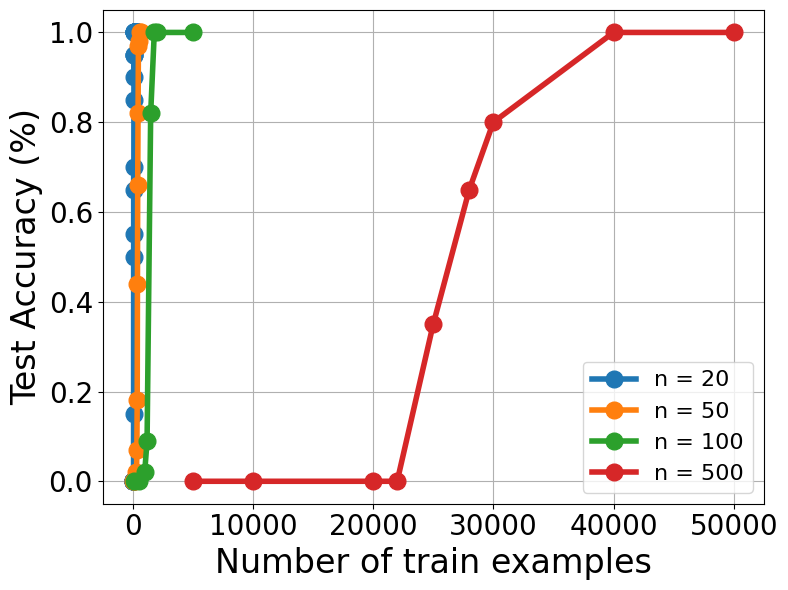

In [40]:
name = 'matrix_completions'

methods = ['plain', 'ar']
numbers = [20,50,100,500]
labels = [f'n = {x}' for x in numbers]

plt.figure(figsize=(8,6))
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # for few-shot prompting evaluation

files = [
    'iterative_mc_results_n=20.csv',
    'iterative_mc_results_n=50.csv',
    'iterative_mc_results_n=100.csv',
    'iterative_mc_results_n=500.csv'
]
print(files)
for i, file in enumerate(files):
    df = pd.read_csv(file)
    keys = df.keys()
    df.sort_values(by=['revealed_entries'], inplace=True)
    # num_ar = df['num_train_samples'].unique()

    # df_mean = df.groupby('num_train_samples').mean()
    # df_min = df.groupby('num_train_samples').min()
    # df_max = df.groupby('num_train_samples').max()

    plt.plot(df.revealed_entries, df.success_prob_values, label=labels[i], color=colors[i], marker='o', linewidth=4, markersize=12)


# plt.title("NanoGPT, Algorithmic Reasoning Accuracy", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlim(700, 7000)
# plt.ylim(0, 100)
# plt.xscale('log')
# plt.xticks([0,5000,10000,15000, 20000, 25000, 30000, 35000, 40000], 
#            ["0", "5k", "10k", "15k", "20k", "25k", "30k", "35k", "40k"], fontsize=20)
plt.xlabel('Number of train examples',fontsize=24)
plt.ylabel('Test Accuracy (%)',fontsize=24)
plt.legend(loc='lower right', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.savefig(f'{name}.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.0)